## Download the model that you want to fine-tune from the Hugging Face model hub

In [1]:
from huggingface_hub import hf_hub_download
import os 
import shutil
from mescnn.classification.inference.download import download_classifier

# Replace this with the path to your local directory
fine_tuning_model_dir = "/home/ubuntu/M1/Data/Fine_tuning/models/"
local_models_dir = "./mescnn/classification/logs/cnn/holdout"

# Create the directory if it does not exist
if not os.path.exists(fine_tuning_model_dir):
    os.makedirs(fine_tuning_model_dir)
    
lesion = "M"

# Download the densenet121_C_V3.pth model
if (lesion == "C"):
    model_id = f"mobilenetv2_{lesion}_V3.pth" # For C lesion
elif (lesion == "S"):
    model_id = f"densenet161_{lesion}_V3.pth" # For S lesion
else:
    model_id = f"efficientnetv2-m_{lesion}_V3.pth" # For M & E lesion


model_name = model_id.split("/")[-1]
splited_model_name = model_name.split("_")
print(splited_model_name)
local_model_path = os.path.join(local_models_dir, model_name)


if not os.path.exists(local_model_path):
    print("Downloading model to {}...".format(local_model_path))
    downloaded_model = download_classifier(splited_model_name[0], splited_model_name[1], splited_model_name[2].split(".")[0])
    # Copy the model from the download directory to the fine_tune directory
    shutil.copy(downloaded_model, os.path.join(fine_tuning_model_dir, model_name))
    print("Download complete.")
else:
    print("Model {} already exists in local directory. Skipping download.".format(model_id))
    shutil.copy(local_model_path, os.path.join(fine_tuning_model_dir, model_name))

['efficientnetv2-m', 'M', 'V3.pth']
Model efficientnetv2-m_M_V3.pth already exists in local directory. Skipping download.


/home/ubuntu/anaconda3/envs/FionnAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fine-tuning the model 

In [2]:
# Load the efficientnet C model
import torch
net = torch.load(local_model_path)

In [131]:
# Show the last layers
print(net)

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
learning_rate = 10**(-5)
momentum = 0.8
batch_size = 4
epochs = 80
augmentation = ['HFlip', 'VFlip', 'BtnsCtst']
frozen = False

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.RandomVerticalFlip(p=0.25),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3)], p=0.25),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.RandomVerticalFlip(p=0.25),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3)], p=0.25),
    ]),
}

data_dir = "/home/ubuntu/M1/Data/Fine_tuning/Classification/" + lesion 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Print the data, and each class, as well as the number associated with each class
print(image_datasets)
print(image_datasets['train'].classes)
print(image_datasets['train'].class_to_idx)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

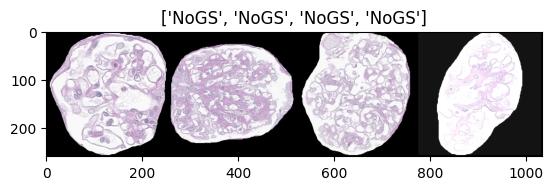

In [137]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
imshow(out, title=[image_datasets['train'].classes[x] for x in classes])

In [138]:
if frozen and lesion != "S":
    # Freeze the net layers except the final layer
    for param in net.parameters():
        param.requires_grad = False

    # Unfreeze the final layer
    for param in net.classifier.parameters():
        param.requires_grad = True

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [139]:
# for param in net.parameters():
#     print(param.requires_grad)

In [ ]:
import wandb

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="projet_m1",

    # track hyperparameters and run metadata
    config={
        "learning_rate": learning_rate,
        "architecture": model_name,
        "dataset": lesion,
        "epochs": epochs,
        "batch_size": batch_size,
        "momentum": momentum,
        "augmentation": augmentation,
        "frozen": frozen,
    }
)

In [141]:
import torch
from torch.utils.data import DataLoader
import time
from tempfile import TemporaryDirectory
import os

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    # Make sure the device is set correctly
    model.to(device)

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # Initially save the current state of the model
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # # Print outputs and labels to debug the model's predictions
                        # if epoch == 0 and phase == 'train':
                        #     print(f"First batch labels and predictions in training: {labels} {preds}")

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if (phase == 'train'):
                    wandb.log({"train_acc": epoch_acc, "train_loss": epoch_loss, "epoch": epoch})
                else:
                    wandb.log({"val_acc": epoch_acc, "val_loss": epoch_loss, "epoch": epoch})

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    wandb.log({"best_val_acc": best_acc})
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return best_acc, model

# Example usage
b_acc, net = train_model(net, criterion, optimizer, dataloaders, dataset_sizes, device, epochs)



Epoch 1
----------
train Loss: 0.8158 Acc: 0.6697
val Loss: 0.4256 Acc: 0.8406

Epoch 2
----------
train Loss: 0.5582 Acc: 0.7829
val Loss: 0.3179 Acc: 0.8768

Epoch 3
----------
train Loss: 0.4802 Acc: 0.8165
val Loss: 0.2736 Acc: 0.9058

Epoch 4
----------
train Loss: 0.4496 Acc: 0.8287
val Loss: 0.2296 Acc: 0.9420

Epoch 5
----------
train Loss: 0.3829 Acc: 0.8471
val Loss: 0.1755 Acc: 0.9420

Epoch 6
----------
train Loss: 0.3816 Acc: 0.8624
val Loss: 0.1508 Acc: 0.9493

Epoch 7
----------
train Loss: 0.3356 Acc: 0.8654
val Loss: 0.1866 Acc: 0.9493

Epoch 8
----------
train Loss: 0.3601 Acc: 0.8593
val Loss: 0.1615 Acc: 0.9493

Epoch 9
----------
train Loss: 0.3379 Acc: 0.8838
val Loss: 0.1554 Acc: 0.9275

Epoch 10
----------
train Loss: 0.3691 Acc: 0.8807
val Loss: 0.1846 Acc: 0.9420

Epoch 11
----------
train Loss: 0.3038 Acc: 0.8930
val Loss: 0.1660 Acc: 0.9493

Epoch 12
----------
train Loss: 0.3558 Acc: 0.8716
val Loss: 0.1774 Acc: 0.9348

Epoch 13
----------
train Loss: 0.32

In [142]:
# End wandb run
wandb.finish()

b_acc = round(b_acc.item(), 4)

# Save the model
torch.save(net, os.path.join(local_models_dir, f"{model_name.split('.')[0]}_{b_acc}_fine_tuned.pth"))

best_val_acc,▁▃▅▇▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▆█▇▇▇▇█▇▇▇██▇▇▇██▇█▇██▇█
train_loss,█▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▃▂▂▁▂▁▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁
val_acc,▁▅▇▇▆▇▇▆█▇▆█▇▅█▆▇▇█▆▇▇▇▇█▆▇▆▆▇▆███▆██▇▇█
val_loss,█▄▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▂▂▁▂▂▂▁▂▂▂▂▁▂▁▁▂▂▁▁▂▁▁
best_val_acc,0.96377
epoch,79
train_acc,0.91437
train_loss,0.22484
val_acc,0.95652


In [143]:
# # Test on all the data to get the accuracy before fine-tuning
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in dataloaders['train']:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print('Accuracy of the network on the {} validation images: {}%'.format(total, 100 * correct / total))

In [144]:
# # Test on all the data to get the accuracy before fine-tuning
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in dataloaders['val']:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print('Accuracy of the network on the {} validation images: {}%'.format(total, 100 * correct / total))